<span style='font-weight:bold; font-size:xx-large'>Machine learning classification</span>

**Author:** *Nikolai Hlubek*

Try to predict the switching using machine learning. 

In [1]:
import os
import pickle

import numpy as np
import pandas as pd

# Static plots
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# Dynamic plots
import plotly.express as px

# Filtering
import scipy.signal

# Jupyter display infrastructure
import IPython.display

# Machine learning library
import sklearn
import sklearn.model_selection
import sklearn.cross_decomposition
import sklearn.cluster
import sklearn.ensemble
import sklearn.svm

# Neuronal networks
import keras

2023-02-04 18:44:49.299888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 18:44:49.393122: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-04 18:44:49.393161: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-04 18:44:49.830854: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Parameters

In [2]:
filename_out = 'intermediate/models#KeilE_success#Transformer.pkl'

# Load data

In [3]:
with open('data/df_current.pkl', 'rb') as file:
    df_current = pickle.load(file)

with open('data/df_voltage.pkl', 'rb') as file:
    df_voltage = pickle.load(file)

with open('data/df_params.pkl', 'rb') as file:
    df_params = pickle.load(file)

In [4]:
X = df_current.copy()

In [5]:
y_bool = df_params['fault']

# Smooth data

In [6]:
X_savgol = X.apply(lambda x: scipy.signal.savgol_filter(x.values, 5, 2, mode='nearest'), axis=1, result_type='broadcast')

(42.0, 45.0)

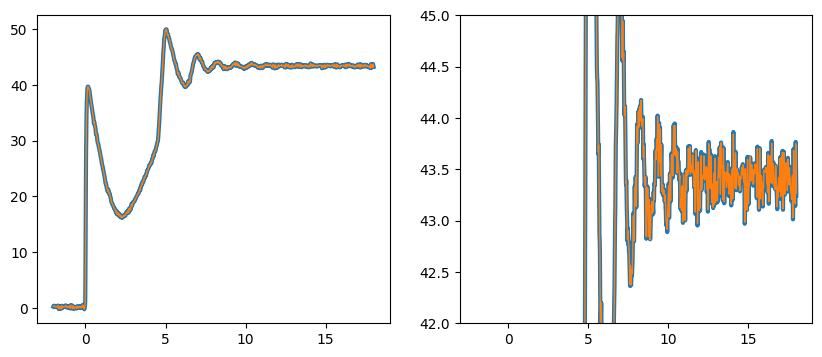

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

idx = 150
ax1.plot(X.loc[idx,:], linewidth=3)
ax1.plot(X_savgol.loc[idx,:], linewidth=1)

ax2.plot(X.loc[idx,:], linewidth=3)
ax2.plot(X_savgol.loc[idx,:], linewidth=1)
ax2.set_ylim(42,45)

# Scaling

In [8]:
X_max = X.div(X.max(axis=1), axis=0)

In [9]:
X_snv = sklearn.preprocessing.scale(X, with_mean=True, with_std=True)

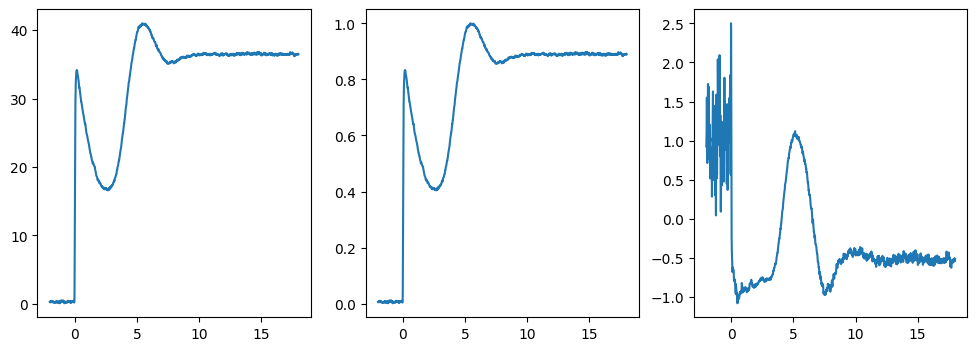

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

ax1.plot(X.loc[2,:])
ax2.plot(X_max.loc[2,:])
ax3.plot(X.columns, X_snv[2,:])

# To categorical

In [11]:
y = y_bool.to_numpy()
y = y.astype('int')

# Metrics

In [12]:
def calc_metrics(y_truth, y_predict, print=False):
    # Calculate scores
    r2_score = sklearn.metrics.r2_score(y_truth, y_predict)
    ev_score = sklearn.metrics.explained_variance_score(y_truth, y_predict)
    mse = sklearn.metrics.mean_squared_error(y_truth, y_predict)
    acc_score = sklearn.metrics.accuracy_score(y_truth, y_predict)
    precision_score_None = sklearn.metrics.precision_score(y_truth, y_predict)
    recall_score_None = sklearn.metrics.recall_score(y_truth, y_predict)
    precision_score_macro = sklearn.metrics.precision_score(y_truth, y_predict, average='macro')
    recall_score_macro= sklearn.metrics.recall_score(y_truth, y_predict, average='macro')
    misclassifications = sklearn.metrics.zero_one_loss(y_truth, y_predict, normalize=False)

    if print:
        print("R2 Score: {:.4f}".format(r2_score))
        print("Explained variance score: {:.4f}".format(ev_score))
        print("Mean squared error: {:.4f}".format(mse))
        print("Total number of misclassifications: {}".format(misclassifications))
        print("Accuracy Score: {:.4f}".format(acc_score))
        print(f"Precision: {np.array2string(precision_score_None, precision=4, floatmode='fixed')}")
        print(f"Recall: {np.array2string(recall_score_None, precision=4, floatmode='fixed')}")
        print(f"Precision macro: {precision_score_macro}")
        print(f"Recall macro: {recall_score_macro}")

    return {'Misclassifications': misclassifications, 'r2 score': r2_score, 'Explained variance score': ev_score, 'Accuracy score': acc_score, 'Precision': precision_score_None, 'Recall': recall_score_None}

In [13]:
def plot_quality(y_truth, y_predict):
    fig, ax = plt.subplots()
    ax.scatter(y_truth, y_predict, edgecolors=(0, 0, 0))
    ax.plot([y_truth.min(), y_truth.max()], [y_truth.min(), y_truth.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    
    return fig, ax

In [14]:
def plot_misclassifications(y_cv, y=y):
    failures_idx = []
    for i in range(len(y)):
        if y[i] != y_cv[i]:
            failures_idx.append(i)

    fig, ax = plt.subplots()

    for idx in failures_idx:
        ax.plot(X.loc[idx])

    ax.set_title('Wrongly classified')
    ax.set_xlabel('time (ms)')
    ax.set_ylabel('current (mA)')

    IPython.display.display(df_params.loc[failures_idx])

# Model storage

In [15]:
model_overview = []

# Machine learning algorithms

In [16]:
def run_multiple(func, X, y, method, model_overview, n=10):
    """
    Run the model a few times to get the best solution
    """
    for i in range(n):
        y_cv = func(X, y, method, model_overview)
        quality = model_overview[-1]
        if i == 0:
            quality_best = quality.copy()
            y_cv_best = y_cv.copy()
        if quality['Misclassifications'] < quality_best['Misclassifications']:        
            quality_best = quality.copy()
            y_cv_best = y_cv.copy()
    
    return y_cv_best

## Transformer

According to  
https://keras.io/examples/timeseries/timeseries_transformer_classification/

In [17]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = keras.layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


def calc_1D_transformer(X, y, method, model_overview):
    # One hot encoding for keras
#    y_ohe = sklearn.preprocessing.OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray()
    
    #get number of columns in training data
    n_timesteps = X.shape[1]
    n_featues = X.shape[2]
    
    head_size = 256 #256
    num_heads = 4
    num_transformer_blocks = 4
    ff_dim = 4
    dropout = 0.25
    mlp_units = [128] # 128
    mlp_dropout = 0.4
    
    n_classes = len(np.unique(y))
    
    inputs = keras.Input(shape=(n_timesteps, n_features))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = keras.layers.GlobalAveragePooling1D(data_format='channels_first')(x)
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation='relu')(x)
        x = keras.layers.Dropout(mlp_dropout)(x)
#    outputs = keras.layers.Dense(n_classes, activation='softmax')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        loss='binary_crossentropy', 
        optimizer='adam',
        metrics=['binary_accuracy'],
#        loss='sparse_categorical_crossentropy', 
#        optimizer='adam',
#        metrics=['sparse_categorical_accuracy'],
    )
    
#    print(model.summary())

    callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

    #model.fit(X, y_ohe, validation_split=0.2, epochs=200, batch_size=64, callbacks=callbacks)
    model.fit(X, y, validation_split=0.2, epochs=200, batch_size=64, callbacks=callbacks)

    y_cv_probability = model.predict(X)
    
    # Transform probablity result to classification using a threshold
    # https://visualstudiomagazine.com/articles/2018/08/30/neural-binary-classification-keras.aspx 
    # Single sigmoid output node holds a value between 0 and 1 that holds the probablity 
    # of the output being in class 1 or not. 
    y_cv_classification = np.array(y_cv_probability).flatten() > 0.1
    y_cv_classification = y_cv_classification.astype(int)
    
    # Inverse one hot encoding
#    y_cv = []
#    for i in range(len(y_cv_ohe)):
#        if y_cv_ohe[i][0] > y_cv_ohe[i][1]:
#            y_cv.append(1)
#        else:
#            y_cv.append(0)

    metrics = calc_metrics(y, y_cv_classification)
    metrics['method'] = method
    metrics['cv'] = y_cv_classification
    metrics['model'] = model
    model_overview.append(metrics)
    # Store intermediate results to file because training takes a long time
    with open(filename_out, 'ab+') as fp:
        pickle.dump(metrics, fp)


    #plot_quality(y, y_cv)

    return y_cv_classification

In [18]:
X_red_raw = X.loc[:,0:7.5].copy()

In [19]:
X_red_max = X_red_raw.div(X_red_raw.max(axis=1), axis=0)
X_red_snv = sklearn.preprocessing.scale(X_red_raw, with_mean=True, with_std=True)

In [20]:
n_features = 1 # Anzahl der Sensoren
X_raw_keras = X_red_raw.values.reshape((X_red_raw.shape[0], X_red_raw.shape[1], n_features))
X_max_keras = X_red_max.values.reshape((X_red_max.shape[0], X_red_max.shape[1], n_features))
X_snv_keras = X_red_snv.reshape((X_red_snv.shape[0], X_red_snv.shape[1], n_features))

In [21]:
y_cv_raw = run_multiple(calc_1D_transformer, X_raw_keras, y, '1D transformer raw', model_overview, n=5)
y_cv_max = run_multiple(calc_1D_transformer, X_max_keras, y, '1D transformer max', model_overview, n=5)
y_cv_snv = run_multiple(calc_1D_transformer, X_snv_keras, y, '1D transformer snv', model_overview, n=5)

2023-02-04 18:44:51.167229: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-04 18:44:51.167272: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-04 18:44:51.167297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cf144ed660ba): /proc/driver/nvidia/version does not exist
2023-02-04 18:44:51.167459: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
18/18 [==============================] - 240s 13s/step - loss: 6.8301 - binary_accuracy: 0.7791 - val_loss: 4.7309 - val_binary_accuracy: 0.6630
Epoch 2/200
18/18 [==============================] - 267s 15s/step - loss: 0.7242 - binary_accuracy: 0.8955 - val_loss: 1.1216 - val_binary_accuracy: 0.8132
Epoch 3/200
18/18 [==============================] - 223s 12s/step - loss: 0.1401 - binary_accuracy: 0.9652 - val_loss: 2.6848 - val_binary_accuracy: 0.7363
Epoch 4/200
18/18 [==============================] - 229s 13s/step - loss: 0.0569 - binary_accuracy: 0.9835 - val_loss: 1.4073 - val_binary_accuracy: 0.8132
Epoch 5/200
18/18 [==============================] - 252s 14s/step - loss: 0.0237 - binary_accuracy: 0.9945 - val_loss: 1.1194 - val_binary_accuracy: 0.8242
Epoch 6/200
18/18 [==============================] - 223s 12s/step - loss: 0.0108 - binary_accuracy: 0.9945 - val_loss: 1.0134 - val_binary_accuracy: 0.8242
Epoch 7/200
18/18 [==============================] - 233s 

File Name                                             Modified             Size
metadata.json                                  2023-02-04 20:13:09           64
config.json                                    2023-02-04 20:13:09        18036
variables.h5                                   2023-02-04 20:13:09      1707864
Epoch 1/200
18/18 [==============================] - 252s 14s/step - loss: 18.3418 - binary_accuracy: 0.7214 - val_loss: 11.5115 - val_binary_accuracy: 0.2015
Epoch 2/200
18/18 [==============================] - 231s 13s/step - loss: 1.2180 - binary_accuracy: 0.8964 - val_loss: 1.5571 - val_binary_accuracy: 0.8315
Epoch 3/200
18/18 [==============================] - 231s 12s/step - loss: 0.4522 - binary_accuracy: 0.9386 - val_loss: 1.7854 - val_binary_accuracy: 0.7985
Epoch 4/200
18/18 [==============================] - 228s 13s/step - loss: 0.0846 - binary_accuracy: 0.9863 - val_loss: 0.7992 - val_binary_accuracy: 0.8901
Epoch 5/200
18/18 [==============================]

File Name                                             Modified             Size
metadata.json                                  2023-02-04 21:22:40           64
config.json                                    2023-02-04 21:22:40        18170
variables.h5                                   2023-02-04 21:22:40      1707864
Epoch 1/200
18/18 [==============================] - 263s 14s/step - loss: 12.7340 - binary_accuracy: 0.7232 - val_loss: 12.9055 - val_binary_accuracy: 0.2125
Epoch 2/200
18/18 [==============================] - 260s 15s/step - loss: 1.0008 - binary_accuracy: 0.9175 - val_loss: 0.4223 - val_binary_accuracy: 0.8938
Epoch 3/200
18/18 [==============================] - 231s 13s/step - loss: 0.2419 - binary_accuracy: 0.9533 - val_loss: 1.0823 - val_binary_accuracy: 0.8242
Epoch 4/200
18/18 [==============================] - 260s 14s/step - loss: 0.0314 - binary_accuracy: 0.9881 - val_loss: 0.7925 - val_binary_accuracy: 0.8352
Epoch 5/200
18/18 [==============================]

Epoch 3/200
18/18 [==============================] - 231s 13s/step - loss: 1.0899 - binary_accuracy: 0.9138 - val_loss: 1.4017 - val_binary_accuracy: 0.8095
Epoch 4/200
18/18 [==============================] - 241s 13s/step - loss: 0.2053 - binary_accuracy: 0.9615 - val_loss: 1.0463 - val_binary_accuracy: 0.8242
Epoch 5/200
18/18 [==============================] - 228s 13s/step - loss: 0.0484 - binary_accuracy: 0.9881 - val_loss: 1.0648 - val_binary_accuracy: 0.8278
Epoch 6/200
18/18 [==============================] - 268s 15s/step - loss: 0.0230 - binary_accuracy: 0.9927 - val_loss: 0.7043 - val_binary_accuracy: 0.8791
Epoch 7/200
18/18 [==============================] - 228s 13s/step - loss: 0.0245 - binary_accuracy: 0.9908 - val_loss: 1.8521 - val_binary_accuracy: 0.7839
Epoch 8/200
18/18 [==============================] - 233s 13s/step - loss: 0.0108 - binary_accuracy: 0.9963 - val_loss: 0.7396 - val_binary_accuracy: 0.8681
Epoch 9/200
18/18 [==============================] - 234s 

Epoch 3/200
18/18 [==============================] - 297s 16s/step - loss: 0.0349 - binary_accuracy: 0.9881 - val_loss: 1.4998 - val_binary_accuracy: 0.8388
Epoch 4/200
18/18 [==============================] - 252s 14s/step - loss: 0.0213 - binary_accuracy: 0.9945 - val_loss: 1.1936 - val_binary_accuracy: 0.8571
Epoch 5/200
18/18 [==============================] - 251s 14s/step - loss: 0.0209 - binary_accuracy: 0.9945 - val_loss: 0.6898 - val_binary_accuracy: 0.9048
Epoch 6/200
18/18 [==============================] - 259s 14s/step - loss: 0.0110 - binary_accuracy: 0.9973 - val_loss: 0.5397 - val_binary_accuracy: 0.9121
Epoch 7/200
18/18 [==============================] - 229s 13s/step - loss: 0.0199 - binary_accuracy: 0.9918 - val_loss: 1.4011 - val_binary_accuracy: 0.8571
Epoch 8/200
18/18 [==============================] - 226s 13s/step - loss: 8.0383e-04 - binary_accuracy: 1.0000 - val_loss: 1.1611 - val_binary_accuracy: 0.8571
Epoch 9/200
18/18 [==============================] - 2

File Name                                             Modified             Size
metadata.json                                  2023-02-05 01:05:22           64
config.json                                    2023-02-05 01:05:22        18206
variables.h5                                   2023-02-05 01:05:22      1707864
Epoch 1/200
18/18 [==============================] - 242s 13s/step - loss: 0.3948 - binary_accuracy: 0.8433 - val_loss: 0.6372 - val_binary_accuracy: 0.6190
Epoch 2/200
18/18 [==============================] - 221s 12s/step - loss: 0.0929 - binary_accuracy: 0.9743 - val_loss: 0.7228 - val_binary_accuracy: 0.7363
Epoch 3/200
18/18 [==============================] - 235s 13s/step - loss: 0.0251 - binary_accuracy: 0.9982 - val_loss: 0.5415 - val_binary_accuracy: 0.7912
Epoch 4/200
18/18 [==============================] - 246s 14s/step - loss: 0.0114 - binary_accuracy: 1.0000 - val_loss: 0.5478 - val_binary_accuracy: 0.8022
Epoch 5/200
18/18 [==============================] -

Epoch 2/200
18/18 [==============================] - 217s 12s/step - loss: 0.0940 - binary_accuracy: 0.9743 - val_loss: 0.7913 - val_binary_accuracy: 0.6850
Epoch 3/200
18/18 [==============================] - 244s 14s/step - loss: 0.0384 - binary_accuracy: 0.9954 - val_loss: 0.6051 - val_binary_accuracy: 0.7692
Epoch 4/200
18/18 [==============================] - 229s 13s/step - loss: 0.0170 - binary_accuracy: 1.0000 - val_loss: 0.5690 - val_binary_accuracy: 0.8022
Epoch 5/200
18/18 [==============================] - 225s 12s/step - loss: 0.0111 - binary_accuracy: 1.0000 - val_loss: 0.5716 - val_binary_accuracy: 0.8022
Epoch 6/200
18/18 [==============================] - 213s 12s/step - loss: 0.0123 - binary_accuracy: 0.9991 - val_loss: 0.6842 - val_binary_accuracy: 0.8022
Epoch 7/200
18/18 [==============================] - 239s 13s/step - loss: 0.0052 - binary_accuracy: 1.0000 - val_loss: 0.6543 - val_binary_accuracy: 0.8022
Epoch 8/200
18/18 [==============================] - 220s 

Epoch 4/200
18/18 [==============================] - 224s 12s/step - loss: 0.0282 - binary_accuracy: 0.9963 - val_loss: 0.4293 - val_binary_accuracy: 0.8242
Epoch 5/200
18/18 [==============================] - 220s 12s/step - loss: 0.0152 - binary_accuracy: 0.9991 - val_loss: 0.5125 - val_binary_accuracy: 0.8059
Epoch 6/200
18/18 [==============================] - 220s 12s/step - loss: 0.0120 - binary_accuracy: 0.9982 - val_loss: 0.4533 - val_binary_accuracy: 0.8352
Epoch 7/200
18/18 [==============================] - 243s 13s/step - loss: 0.0097 - binary_accuracy: 0.9991 - val_loss: 0.3984 - val_binary_accuracy: 0.8352
Epoch 8/200
18/18 [==============================] - 248s 13s/step - loss: 0.0065 - binary_accuracy: 1.0000 - val_loss: 0.3977 - val_binary_accuracy: 0.8462
Epoch 9/200
18/18 [==============================] - 214s 12s/step - loss: 0.0060 - binary_accuracy: 1.0000 - val_loss: 0.5151 - val_binary_accuracy: 0.8352
Epoch 10/200
18/18 [==============================] - 216s

Epoch 7/200
18/18 [==============================] - 211s 12s/step - loss: 0.0064 - binary_accuracy: 1.0000 - val_loss: 0.6042 - val_binary_accuracy: 0.8132
Epoch 8/200
18/18 [==============================] - 239s 13s/step - loss: 0.0038 - binary_accuracy: 1.0000 - val_loss: 0.5014 - val_binary_accuracy: 0.8352
Epoch 9/200
18/18 [==============================] - 226s 13s/step - loss: 0.0031 - binary_accuracy: 1.0000 - val_loss: 0.5235 - val_binary_accuracy: 0.8352
Epoch 10/200
18/18 [==============================] - 223s 12s/step - loss: 0.0031 - binary_accuracy: 1.0000 - val_loss: 0.5352 - val_binary_accuracy: 0.8352
Epoch 11/200
18/18 [==============================] - 254s 14s/step - loss: 0.0025 - binary_accuracy: 1.0000 - val_loss: 0.6656 - val_binary_accuracy: 0.8132
Epoch 12/200
18/18 [==============================] - 230s 13s/step - loss: 0.0015 - binary_accuracy: 1.0000 - val_loss: 0.5778 - val_binary_accuracy: 0.8352
Epoch 13/200
18/18 [==============================] - 2

Epoch 7/200
18/18 [==============================] - 215s 12s/step - loss: 0.0086 - binary_accuracy: 1.0000 - val_loss: 0.4488 - val_binary_accuracy: 0.8352
Epoch 8/200
18/18 [==============================] - 216s 12s/step - loss: 0.0067 - binary_accuracy: 1.0000 - val_loss: 0.3908 - val_binary_accuracy: 0.8388
Epoch 9/200
18/18 [==============================] - 238s 13s/step - loss: 0.0057 - binary_accuracy: 1.0000 - val_loss: 0.4149 - val_binary_accuracy: 0.8352
Epoch 10/200
18/18 [==============================] - 227s 13s/step - loss: 0.0048 - binary_accuracy: 0.9991 - val_loss: 0.5446 - val_binary_accuracy: 0.8168
Epoch 11/200
18/18 [==============================] - 237s 13s/step - loss: 0.0041 - binary_accuracy: 1.0000 - val_loss: 0.5159 - val_binary_accuracy: 0.8352
Epoch 12/200
18/18 [==============================] - 226s 13s/step - loss: 0.0054 - binary_accuracy: 0.9991 - val_loss: 0.3055 - val_binary_accuracy: 0.9121
Epoch 13/200
18/18 [==============================] - 2

Epoch 1/200
18/18 [==============================] - 241s 13s/step - loss: 0.1239 - binary_accuracy: 0.9432 - val_loss: 0.1348 - val_binary_accuracy: 0.9560
Epoch 2/200
18/18 [==============================] - 229s 12s/step - loss: 0.0024 - binary_accuracy: 1.0000 - val_loss: 0.2893 - val_binary_accuracy: 0.9011
Epoch 3/200
18/18 [==============================] - 228s 13s/step - loss: 0.0015 - binary_accuracy: 0.9991 - val_loss: 0.2804 - val_binary_accuracy: 0.9158
Epoch 4/200
18/18 [==============================] - 222s 12s/step - loss: 5.6255e-04 - binary_accuracy: 1.0000 - val_loss: 0.3773 - val_binary_accuracy: 0.8828
Epoch 5/200
18/18 [==============================] - 236s 13s/step - loss: 3.4635e-04 - binary_accuracy: 1.0000 - val_loss: 0.3898 - val_binary_accuracy: 0.8755
Epoch 6/200
18/18 [==============================] - 247s 14s/step - loss: 2.0439e-04 - binary_accuracy: 1.0000 - val_loss: 0.4404 - val_binary_accuracy: 0.8645
Epoch 7/200
18/18 [===========================

18/18 [==============================] - 232s 13s/step - loss: 6.2986e-04 - binary_accuracy: 1.0000 - val_loss: 0.2679 - val_binary_accuracy: 0.8938
Epoch 6/200
18/18 [==============================] - 216s 12s/step - loss: 3.6207e-04 - binary_accuracy: 1.0000 - val_loss: 0.2323 - val_binary_accuracy: 0.9084
Epoch 7/200
18/18 [==============================] - 243s 13s/step - loss: 2.6469e-04 - binary_accuracy: 1.0000 - val_loss: 0.2065 - val_binary_accuracy: 0.9158
Epoch 8/200
18/18 [==============================] - 249s 14s/step - loss: 2.0968e-04 - binary_accuracy: 1.0000 - val_loss: 0.2298 - val_binary_accuracy: 0.9158
Epoch 9/200
18/18 [==============================] - 226s 12s/step - loss: 3.3393e-04 - binary_accuracy: 1.0000 - val_loss: 0.2264 - val_binary_accuracy: 0.9158
Epoch 10/200
18/18 [==============================] - 218s 12s/step - loss: 1.4503e-04 - binary_accuracy: 1.0000 - val_loss: 0.2852 - val_binary_accuracy: 0.8901
Epoch 11/200
43/43 [=========================

18/18 [==============================] - 292s 16s/step - loss: 1.7923e-04 - binary_accuracy: 1.0000 - val_loss: 0.4822 - val_binary_accuracy: 0.8608
Epoch 10/200
18/18 [==============================] - 258s 14s/step - loss: 7.3733e-05 - binary_accuracy: 1.0000 - val_loss: 0.4359 - val_binary_accuracy: 0.8681
Epoch 11/200
18/18 [==============================] - 367s 17s/step - loss: 9.6746e-05 - binary_accuracy: 1.0000 - val_loss: 0.5033 - val_binary_accuracy: 0.8608
Epoch 12/200
43/43 [==============================] - 92s 2s/step
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv1d
.........vars
............0
............1
......conv1d_1
.........vars
............0
............1
......conv1d_2
.........vars
............0
............1
......conv1d_3
.........vars
............0
............1
......conv1d_4
.........vars
............0
............1
......conv1d_5
.........vars
............0
............1
......conv1d_6
.........vars
............0
..

18/18 [==============================] - 221s 12s/step - loss: 7.5341e-05 - binary_accuracy: 1.0000 - val_loss: 0.3798 - val_binary_accuracy: 0.8681
Epoch 13/200
43/43 [==============================] - 89s 2s/step
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv1d
.........vars
............0
............1
......conv1d_1
.........vars
............0
............1
......conv1d_2
.........vars
............0
............1
......conv1d_3
.........vars
............0
............1
......conv1d_4
.........vars
............0
............1
......conv1d_5
.........vars
............0
............1
......conv1d_6
.........vars
............0
............1
......conv1d_7
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......dropout_4
.........va

...............1
........._output_dense
............vars
...............0
...............1
........._query_dense
............vars
...............0
...............1
........._softmax
............vars
........._value_dense
............vars
...............0
...............1
.........vars
......multi_head_attention_3
........._dropout_layer
............vars
........._key_dense
............vars
...............0
...............1
........._output_dense
............vars
...............0
...............1
........._query_dense
............vars
...............0
...............1
........._softmax
............vars
........._value_dense
............vars
...............0
...............1
.........vars
......tf_op_lambda
.........vars
......tf_op_lambda_1
.........vars
......tf_op_lambda_2
.........vars
......tf_op_lambda_3
.........vars
......tf_op_lambda_4
.........vars
......tf_op_lambda_5
.........vars
......tf_op_lambda_6
.........vars
......tf_op_lambda_7
.........vars
...metrics
......mean
....

In [22]:
pd.DataFrame(model_overview)

,Misclassifications,r2 score,Explained variance score,Accuracy score,Precision,Recall,method,cv,model
0,33,0.884272,0.887072,0.975806,1.000000,0.918719,1D transformer raw,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
1,24,0.915835,0.916668,0.982405,0.992268,0.948276,1D transformer raw,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
2,94,0.670352,0.679608,0.931085,0.834764,0.958128,1D transformer raw,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
3,23,0.919341,0.920270,0.983138,0.994832,0.948276,1D transformer raw,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
4,103,0.638790,0.660081,0.924487,0.804829,0.985222,1D transformer raw,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
5,29,0.898300,0.899228,0.978739,0.987080,0.940887,1D transformer max,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
6,29,0.898300,0.899228,0.978739,0.987080,0.940887,1D transformer max,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
7,88,0.691393,0.698345,0.935484,0.847162,0.955665,1D transformer max,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
8,22,0.922848,0.923877,0.983871,0.997409,0.948276,1D transformer max,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
9,34,0.880766,0.880776,0.975073,0.960396,0.955665,1D transformer max,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...


,nominal width in mm,diaphragm,coil mode,voltage in V,T in °C,supply pressure in bar,back pressure in bar,fault,fault mode,repetition,valve id,integral value,distance in V,tail slope in mA/s
810,1.2,FFKM,100%ED,24.0,15.0,0.0,0.0,False,nA,1,3,1.82,NaN,0.0170
1194,1.2,FFKM,Umgebung,24.0,22.0,1.0,0.0,True,Keil_2,1,7,1.28,0.467196,0.0023
1195,1.2,FFKM,Umgebung,24.0,22.0,1.0,0.0,True,Keil_2,2,7,1.32,0.467821,-0.0157
1196,1.2,FFKM,Umgebung,24.0,22.0,1.0,0.0,True,Keil_2,3,7,1.28,0.467196,0.0023
1253,1.2,FFKM,Umgebung,24.0,22.0,1.0,0.0,True,Keil_2,1,8,1.42,0.519507,0.0073
1254,1.2,FFKM,Umgebung,24.0,22.0,1.0,0.0,True,Keil_2,2,8,1.41,0.518717,0.0007
1255,1.2,FFKM,Umgebung,24.0,22.0,1.0,0.0,True,Keil_2,3,8,1.42,0.519507,0.0073
1256,1.2,FFKM,Umgebung,24.0,22.0,1.0,0.0,True,Keil_4,1,8,1.29,0.478597,0.0038
1257,1.2,FFKM,Umgebung,24.0,22.0,1.0,0.0,True,Keil_4,2,8,1.33,0.480419,0.0176
1258,1.2,FFKM,Umgebung,24.0,22.0,1.0,0.0,True,Keil_4,3,8,1.29,0.478597,0.0038


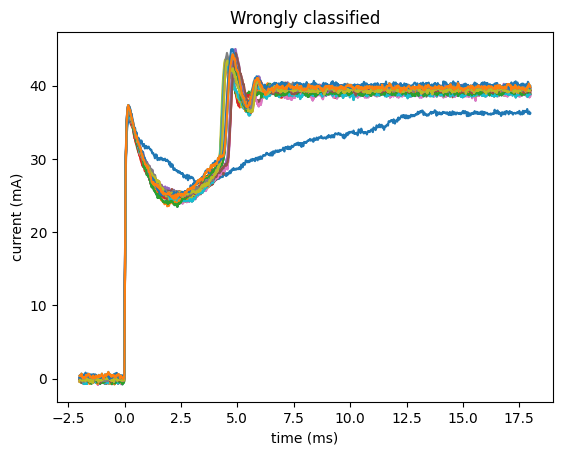

In [23]:
plot_misclassifications(y_cv_max)

,nominal width in mm,diaphragm,coil mode,voltage in V,T in °C,supply pressure in bar,back pressure in bar,fault,fault mode,repetition,valve id,integral value,distance in V,tail slope in mA/s
1253,1.2,FFKM,Umgebung,24.0,22.0,1.0,0.0,True,Keil_2,1,8,1.42,0.519507,0.0073
1254,1.2,FFKM,Umgebung,24.0,22.0,1.0,0.0,True,Keil_2,2,8,1.41,0.518717,0.0007
1255,1.2,FFKM,Umgebung,24.0,22.0,1.0,0.0,True,Keil_2,3,8,1.42,0.519507,0.0073
1283,1.2,FFKM,Umgebung,24.0,22.0,3.0,0.0,True,Keil_2,1,8,1.38,0.512496,-0.0006
1284,1.2,FFKM,Umgebung,24.0,22.0,3.0,0.0,True,Keil_2,2,8,1.39,0.502753,0.0015
1285,1.2,FFKM,Umgebung,24.0,22.0,3.0,0.0,True,Keil_2,3,8,1.38,0.512496,-0.0006
1313,1.2,FFKM,Umgebung,24.0,22.0,1.0,0.0,True,Keil_2,1,9,1.41,0.513487,-0.0132
1314,1.2,FFKM,Umgebung,24.0,22.0,1.0,0.0,True,Keil_2,2,9,1.42,0.516397,-0.0075
1315,1.2,FFKM,Umgebung,24.0,22.0,1.0,0.0,True,Keil_2,3,9,1.41,0.513487,-0.0132


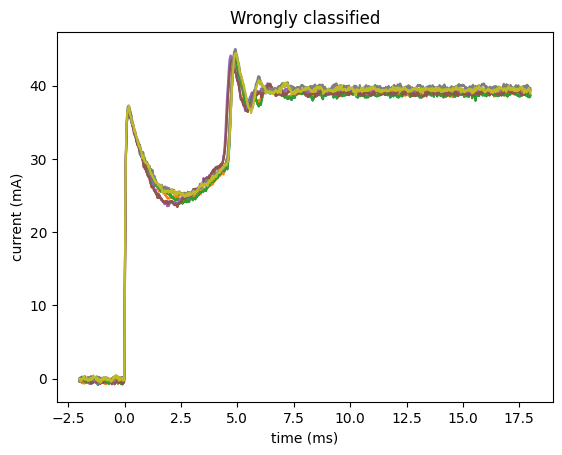

In [24]:
plot_misclassifications(y_cv_snv)

In [25]:
pd.DataFrame(model_overview)

,Misclassifications,r2 score,Explained variance score,Accuracy score,Precision,Recall,method,cv,model
0,33,0.884272,0.887072,0.975806,1.000000,0.918719,1D transformer raw,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
1,24,0.915835,0.916668,0.982405,0.992268,0.948276,1D transformer raw,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
2,94,0.670352,0.679608,0.931085,0.834764,0.958128,1D transformer raw,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
3,23,0.919341,0.920270,0.983138,0.994832,0.948276,1D transformer raw,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
4,103,0.638790,0.660081,0.924487,0.804829,0.985222,1D transformer raw,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
5,29,0.898300,0.899228,0.978739,0.987080,0.940887,1D transformer max,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
6,29,0.898300,0.899228,0.978739,0.987080,0.940887,1D transformer max,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
7,88,0.691393,0.698345,0.935484,0.847162,0.955665,1D transformer max,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
8,22,0.922848,0.923877,0.983871,0.997409,0.948276,1D transformer max,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
9,34,0.880766,0.880776,0.975073,0.960396,0.955665,1D transformer max,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
